In [4]:
import numpy as np
import open3d as o3d
import cv2
import trimesh
import pickle
import jedi
import yaml
from collections import Counter
from tqdm import tqdm
import time
import statistics
import copy
import matplotlib.pyplot as plt
import json
import pandas as pd
pd.set_option('display.max_colwidth', None)
import cv2
import matplotlib.pyplot as plt


def r_t_to_point_cloud(R,t, model_points, color):
    model_points_transformed = np.dot(R, model_points.T).T + t
    point_cloud_object = o3d.geometry.PointCloud()
    point_cloud_object.points = o3d.utility.Vector3dVector(model_points_transformed)

    num_points = len(point_cloud_object.points)
    colors = [color for i in range(num_points)]
    point_cloud_object.colors = o3d.utility.Vector3dVector(colors)
    return point_cloud_object

def r_t_to_points(R,t,model_points):
    model_points_transformed = np.dot(R, model_points.T).T + t
    return model_points_transformed
        

def create_rgbd_image(img,depth_img,camera_intrinsic,color):
    rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(o3d.geometry.Image(img), o3d.geometry.Image(depth_img),
                                                                     depth_scale=1.0, depth_trunc=10000.0, convert_rgb_to_intensity=False)
    pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image, camera_intrinsic)

    num_points = len(pcd.points)
    colors = [color for i in range(num_points)]
    pcd.colors = o3d.utility.Vector3dVector(colors)
    return pcd



In [7]:
print("LOADING MESHES")

fx = 1069.86
fy = 1069.81
cx = 929.96
cy = 540.947

fx = 572.4114
fy = 573.57043
cx = 325.2611
cy = 242.04899

K = np.array([[fx, 0., cx], [0., fy, cy], [0., 0., 1.]], dtype = np.float32)
camera_intrinsic = o3d.camera.PinholeCameraIntrinsic(width=640, height=480,
                                                     fx=fx, fy=fy,
                                                     cx=cx, cy=cy)

print("LOADING RESULTS")

img = cv2.imread('/home/max/Documents/blenderproc/output/bop_data/chess/train/000000/rgb/0019.jpg')

depth_img_path = '/home/max/Documents/blenderproc/output/bop_data/chess/train/000000/depth/0019.png'
depth_img = cv2.imread(depth_img_path, cv2.IMREAD_ANYDEPTH)
# Generate the filename for the current image number

scene_gt_pose = "/home/max/Documents/blenderproc/output/bop_data/chess/train/000000/scene_gt.json"
with open(scene_gt_pose, 'r') as json_file:
    scene_gt_pose = json.load(json_file)
    scene_gt_pose_0 = scene_gt_pose['0']

pcd = create_rgbd_image(img,depth_img,camera_intrinsic,[1,0,0])

point_cloud_object_gts = []
for i, obj_info in enumerate(scene_gt_pose_0):
    cam_R_m2c = obj_info['cam_R_m2c']
    cam_t_m2c = obj_info['cam_t_m2c']
    
    obj = obj_info['obj_id']
    mesh = trimesh.load(f'/home/max/Documents/blenderproc/datasets/models/chess/models/obj_00000{obj}.ply')
    model_points = np.array(mesh.vertices, dtype=np.float32)*10  # convert to meters

    R_gt = np.array([[cam_R_m2c[0], cam_R_m2c[1], cam_R_m2c[2]], [cam_R_m2c[3], cam_R_m2c[4], cam_R_m2c[5]], [cam_R_m2c[6], cam_R_m2c[7], cam_R_m2c[8]]],dtype=np.float64)
    t_gt = np.array([cam_t_m2c[0], cam_t_m2c[1], cam_t_m2c[2]],dtype=np.float64) *10

    # Create Open3D point cloud from RGB-D data
    point_cloud_object_gt = r_t_to_point_cloud(R_gt,t_gt,model_points,[0,1,0])
    point_cloud_object_gts.append(point_cloud_object_gt)

o3d.visualization.draw_geometries([ pcd]+point_cloud_object_gts)

print("DONE")

LOADING MESHES
LOADING RESULTS
DONE


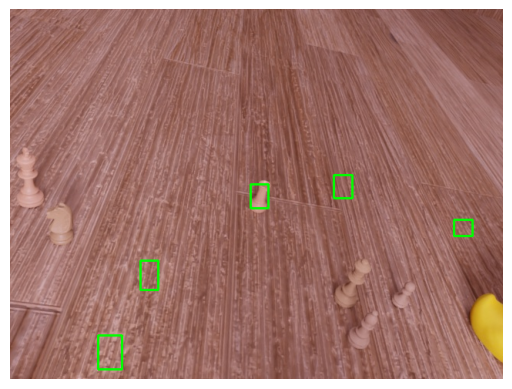

In [6]:
bbox_file = "/home/max/Documents/blenderproc/output/bop_data/chess/train/000000/scene_gt_info.json"
        
with open(bbox_file, 'r') as json_file:
    bbox_data = json.load(json_file)
    
bbox_obj_values = [item['bbox_obj'] for item in bbox_data['0']]

for i, bbox in enumerate(bbox_obj_values):
    x, y, w, h = bbox
    cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)

# Convert the image from BGR to RGB
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Display the image with the bounding box using matplotlib
plt.imshow(img_rgb)
plt.axis('off')
plt.show()


In [15]:

fx = 572.4114
fy = 573.57043
cx = 325.2611
cy = 242.04899

K = np.array([[fx, 0., cx], [0., fy, cy], [0., 0., 1.]], dtype = np.float32)
camera_intrinsic = o3d.camera.PinholeCameraIntrinsic(width=640, height=480,
                                                     fx=fx, fy=fy,
                                                     cx=cx, cy=cy)

print("LOADING RESULTS")

img = cv2.imread('/home/max/Documents/blenderproc/output/bop_data/chess/train/000000/rgb/0001.jpg')
img = cv2.imread('/home/max/Documents/EfficientPose/test/000003.jpg')

depth_img_path = '/home/max/Documents/GitHub/thesis/output/bop_data/backup/train_pbr/000000/depth/000003.png'
depth_img = cv2.imread(depth_img_path, cv2.IMREAD_ANYDEPTH)
# Generate the filename for the current image number

pcd = create_rgbd_image(img,depth_img,camera_intrinsic,[1,0,0])

cam_R_m2c =[ 0.78071086,  0.62487638,  0.00447609,
       -0.62476171,  0.78038105,  0.02604223,
        0.01278012, -0.02312794,  0.99965082]


cam_t_m2c = [ 6.3542682e-01, -3.1421638e-01,  7.7766919e+02]

#cam_R_m2c, cam_t_m2c = flip_axes(cam_R_m2c,cam_t_m2c)

mesh = trimesh.load(f'/home/max/Documents/blenderproc/datasets/models/chess/models/obj_000001.ply')
model_points = np.array(mesh.vertices, dtype=np.float32)*10  # convert to meters

R_gt = np.array([[cam_R_m2c[0], cam_R_m2c[1], cam_R_m2c[2]], [cam_R_m2c[3], cam_R_m2c[4], cam_R_m2c[5]], [cam_R_m2c[6], cam_R_m2c[7], cam_R_m2c[8]]],dtype=np.float64)
t_gt = np.array([cam_t_m2c[0], cam_t_m2c[1], cam_t_m2c[2]],dtype=np.float64) *10

# Create Open3D point cloud from RGB-D data
point_cloud_object_gt = r_t_to_point_cloud(R_gt,t_gt,model_points,[0,1,0])

o3d.visualization.draw_geometries([ pcd,point_cloud_object_gt])

print("DONE")

LOADING RESULTS
DONE


In [17]:
import numpy as np

def flip_axes(cam_R_m2c, cam_t_m2c):
    # Flip the z-axis
    flip_transform = np.array([[-1, 0, 0, 0],
                               [0, -1, 0, 0],
                               [0, 0, 1, 0],
                               [0, 0, 0, 1]], dtype=np.float64)
    cam_R_m2c = np.reshape(cam_R_m2c, (3, 3))
    cam_t_m2c = np.reshape(cam_t_m2c, (3, 1))
    cam_R_m2c = np.dot(flip_transform[:3, :3], cam_R_m2c)
    cam_t_m2c = np.dot(flip_transform[:3, :3], cam_t_m2c)
    return cam_R_m2c.flatten(), cam_t_m2c.flatten()

